# GRN Inference on Pre-trained Model
Here we use the pre-trained blood model as an example for GRN inference, particularly regarding gene program extraction and network visualization. We also present the cell-type specific activations within these gene programs on the Immune Human dataset, as a soft validation for the zero-shot performance. 

Note that GRN inference can be performed on pre-trained and finetuned models as showcased in our manuscript.

Users may perform scGPT's gene-embedding-based GRN inference in the following steps:

     1. Load optimized scGPT model (pre-trained or fine-tuned) and data
     
     2. Retrieve scGPT's gene embeddings
     
     3. Extract gene programs from scGPT's gene embedding network
     
     4. Visualize gene program activations on dataset of interest
     
     5. Visualize the interconnectivity of genes within select gene programs
     

In [3]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings
warnings.simplefilter(action='ignore')

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.append("../")
import scgpt as scg
from scgpt_.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"

In [4]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

# Step 1: Load pre-trained model and dataset

## 1.1  Load pre-trained model

In [6]:
# Specify model path; here we load the pre-trained scGPT blood model
model_dir = Path("/scratch/ssd004/datasets/cellxgene/save/blood_legacy/epoch1_cellxgene-Apr22-19-03-2023")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /scratch/ssd004/datasets/cellxgene/save/blood_legacy/epoch1_cellxgene-Apr22-19-03-2023/best_model.pt, the model args will override the config /scratch/ssd004/datasets/cellxgene/save/blood_legacy/epoch1_cellxgene-Apr22-19-03-2023/args.json.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Using simple batchnorm instead of domain specific batchnorm
Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Lo

Loading params transformer_encoder.layers.8.norm1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.8.norm2.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.8.norm2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.9.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.9.linear1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.linear2.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.9.linear2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm1.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm1.bias with shape torch.Size([512])
Loading params tr

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(36574, 512, padding_idx=36571)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features

## 1.2  Load dataset of interest

In [7]:
# Specify data path; here we load the Immune Human dataset
data_dir = Path("/scratch/ssd004/scratch/chloexq/data/scib_datasets")
adata = sc.read(
    str(data_dir / "Immune_ALL_human.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = False

In [8]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


# Step 2: Retrieve scGPT's gene embeddings

Note that technically scGPT's gene embeddings are data independent. Overall, the pre-trained foundation model contains 30+K genes. Here for simplicity, we focus on a subset of HVGs specific to the data at hand.

In [24]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [25]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1173 genes.


In [26]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 1173/1173 [00:00<00:00, 322152.87it/s]


# Step 3: Extract gene programs from gene embedding network

## 3.1  Perform Louvain clustering on the gene embedding network

In [39]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

## 3.2  Filter on clusters with 5 or more genes

In [40]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [41]:
# Here are the gene programs identified
mgs

{'46': ['ZNF683', 'JAKMIP1', 'LAG3', 'FKBP11', 'ZBP1'],
 '7': ['ZFP36', 'TNFAIP3', 'DUSP1', 'FOS', 'CD69', 'KLF6', 'PPP1R15A', 'JUN'],
 '34': ['YPEL4', 'TMEM86B', 'TMEM63B', 'CYB5R1', 'RUNDC3A', 'DNAJB2'],
 '25': ['YPEL3', 'TLE1', 'CXXC5', 'RBM38', 'ODC1', 'TFDP2'],
 '43': ['YOD1', 'FLCN', 'CPEB4', 'FBXO30', 'MTMR3'],
 '14': ['VSIG4', 'C1QA', 'C1QC', 'C1QB', 'ACP5', 'CD163', 'ABCG2'],
 '71': ['VPREB3', 'VPREB1', 'SOCS2', 'IGLL1', 'DNTT'],
 '17': ['UROD', 'CMAS', 'CDC27', 'MINPP1', 'CPOX', 'RFESD'],
 '58': ['UBE2O', 'FN3K', 'PIM1', 'PNP', 'TRIM58'],
 '47': ['TXK', 'SPOCK2', 'SKAP1', 'CD96', 'RNF125'],
 '22': ['TTN', 'ICA1L', 'KCNQ1OT1', 'BCL9L', 'ABCA5', 'GPR82'],
 '27': ['TSC22D1', 'MEG3', 'PTCRA', 'PGRMC1', 'MLH3', 'GRAP2'],
 '21': ['TRAT1', 'LEF1', 'RCAN3', 'BCL11B', 'TCF7', 'OXNAD1'],
 '0': ['TPX2',
  'STMN1',
  'UBE2C',
  'MKI67',
  'TOP2A',
  'CCNB1',
  'CDK1',
  'TYMS',
  'TK1',
  'NUSAP1',
  'BIRC5',
  'PTTG1',
  'CENPF',
  'RRM2'],
 '8': ['TPM2', 'TPM1', 'TGFB1I1', 'CALD1', 'MY

# Step 4: Visualize gene program activation on the Immune Human dataset

<Figure size 360x936 with 0 Axes>

<Figure size 432x288 with 0 Axes>

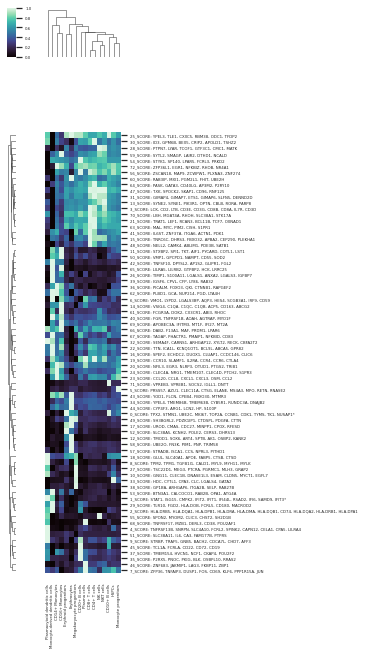

In [42]:
sns.set(font_scale=0.35)
embed.score_metagenes(adata, metagenes)
embed.plot_metagenes_scores(adata, mgs, "celltype")

# Step 5: Visualize gene program activation on the Immune Human dataset

# Step 6: Reactome pathway analysis

In [30]:
reactome = open("references/Reactome_2022.txt", "r").readlines()
pathways = dict()
for pathway in reactome:
    pathway = pathway.strip().split("\t")
    name = pathway[0]
    genes = pathway[2:]
    pathways[name] = genes

/h/chloexq/.cache/pypoetry/virtualenvs/scgpt--qSLVbd1-py3.9/lib/python3.7/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.TextIOWrapper name='references/Reactome_2022.txt' mode='r' encoding='UTF-8'>
  """Entry point for launching an IPython kernel.


In [31]:
import pandas as pd
import tqdm

In [32]:
# Rmb to not filter the HVGs when generating the CD figure!!!

In [33]:
out_immune = list(set(pathways['Immune System R-HSA-168256'])) + ['CD3G']
CD_genes = [i for i in list(gene_embeddings.keys()) if 'CD' in i]
print(len(CD_genes))
CD_gene = [i for i in CD_genes if i in out_immune]
print(len(CD_genes))

54
54


In [34]:
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = df_CD.append(df)

100%|██████████| 54/54 [00:00<00:00, 65.94it/s]


In [35]:
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene')

In [36]:
df_CD_sub

Gene  Similarity   Gene1
16  CCDC141    0.075887   CD247
21  CCDC141    0.055977    CD19
47  CCDC141   -0.104277   CD302
12  CCDC141    0.075736    CD55
20  CCDC141    0.033687    CD3G
..      ...         ...     ...
46    PCDH9   -0.051916   CD226
7     PCDH9    0.254652   CD79B
26    PCDH9    0.057030  CDC25B
13    PCDH9    0.104865    CD36
6     PCDH9    0.229109    CD19

[2862 rows x 3 columns]

In [37]:
import networkx as nx

In [38]:
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]

In [39]:
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

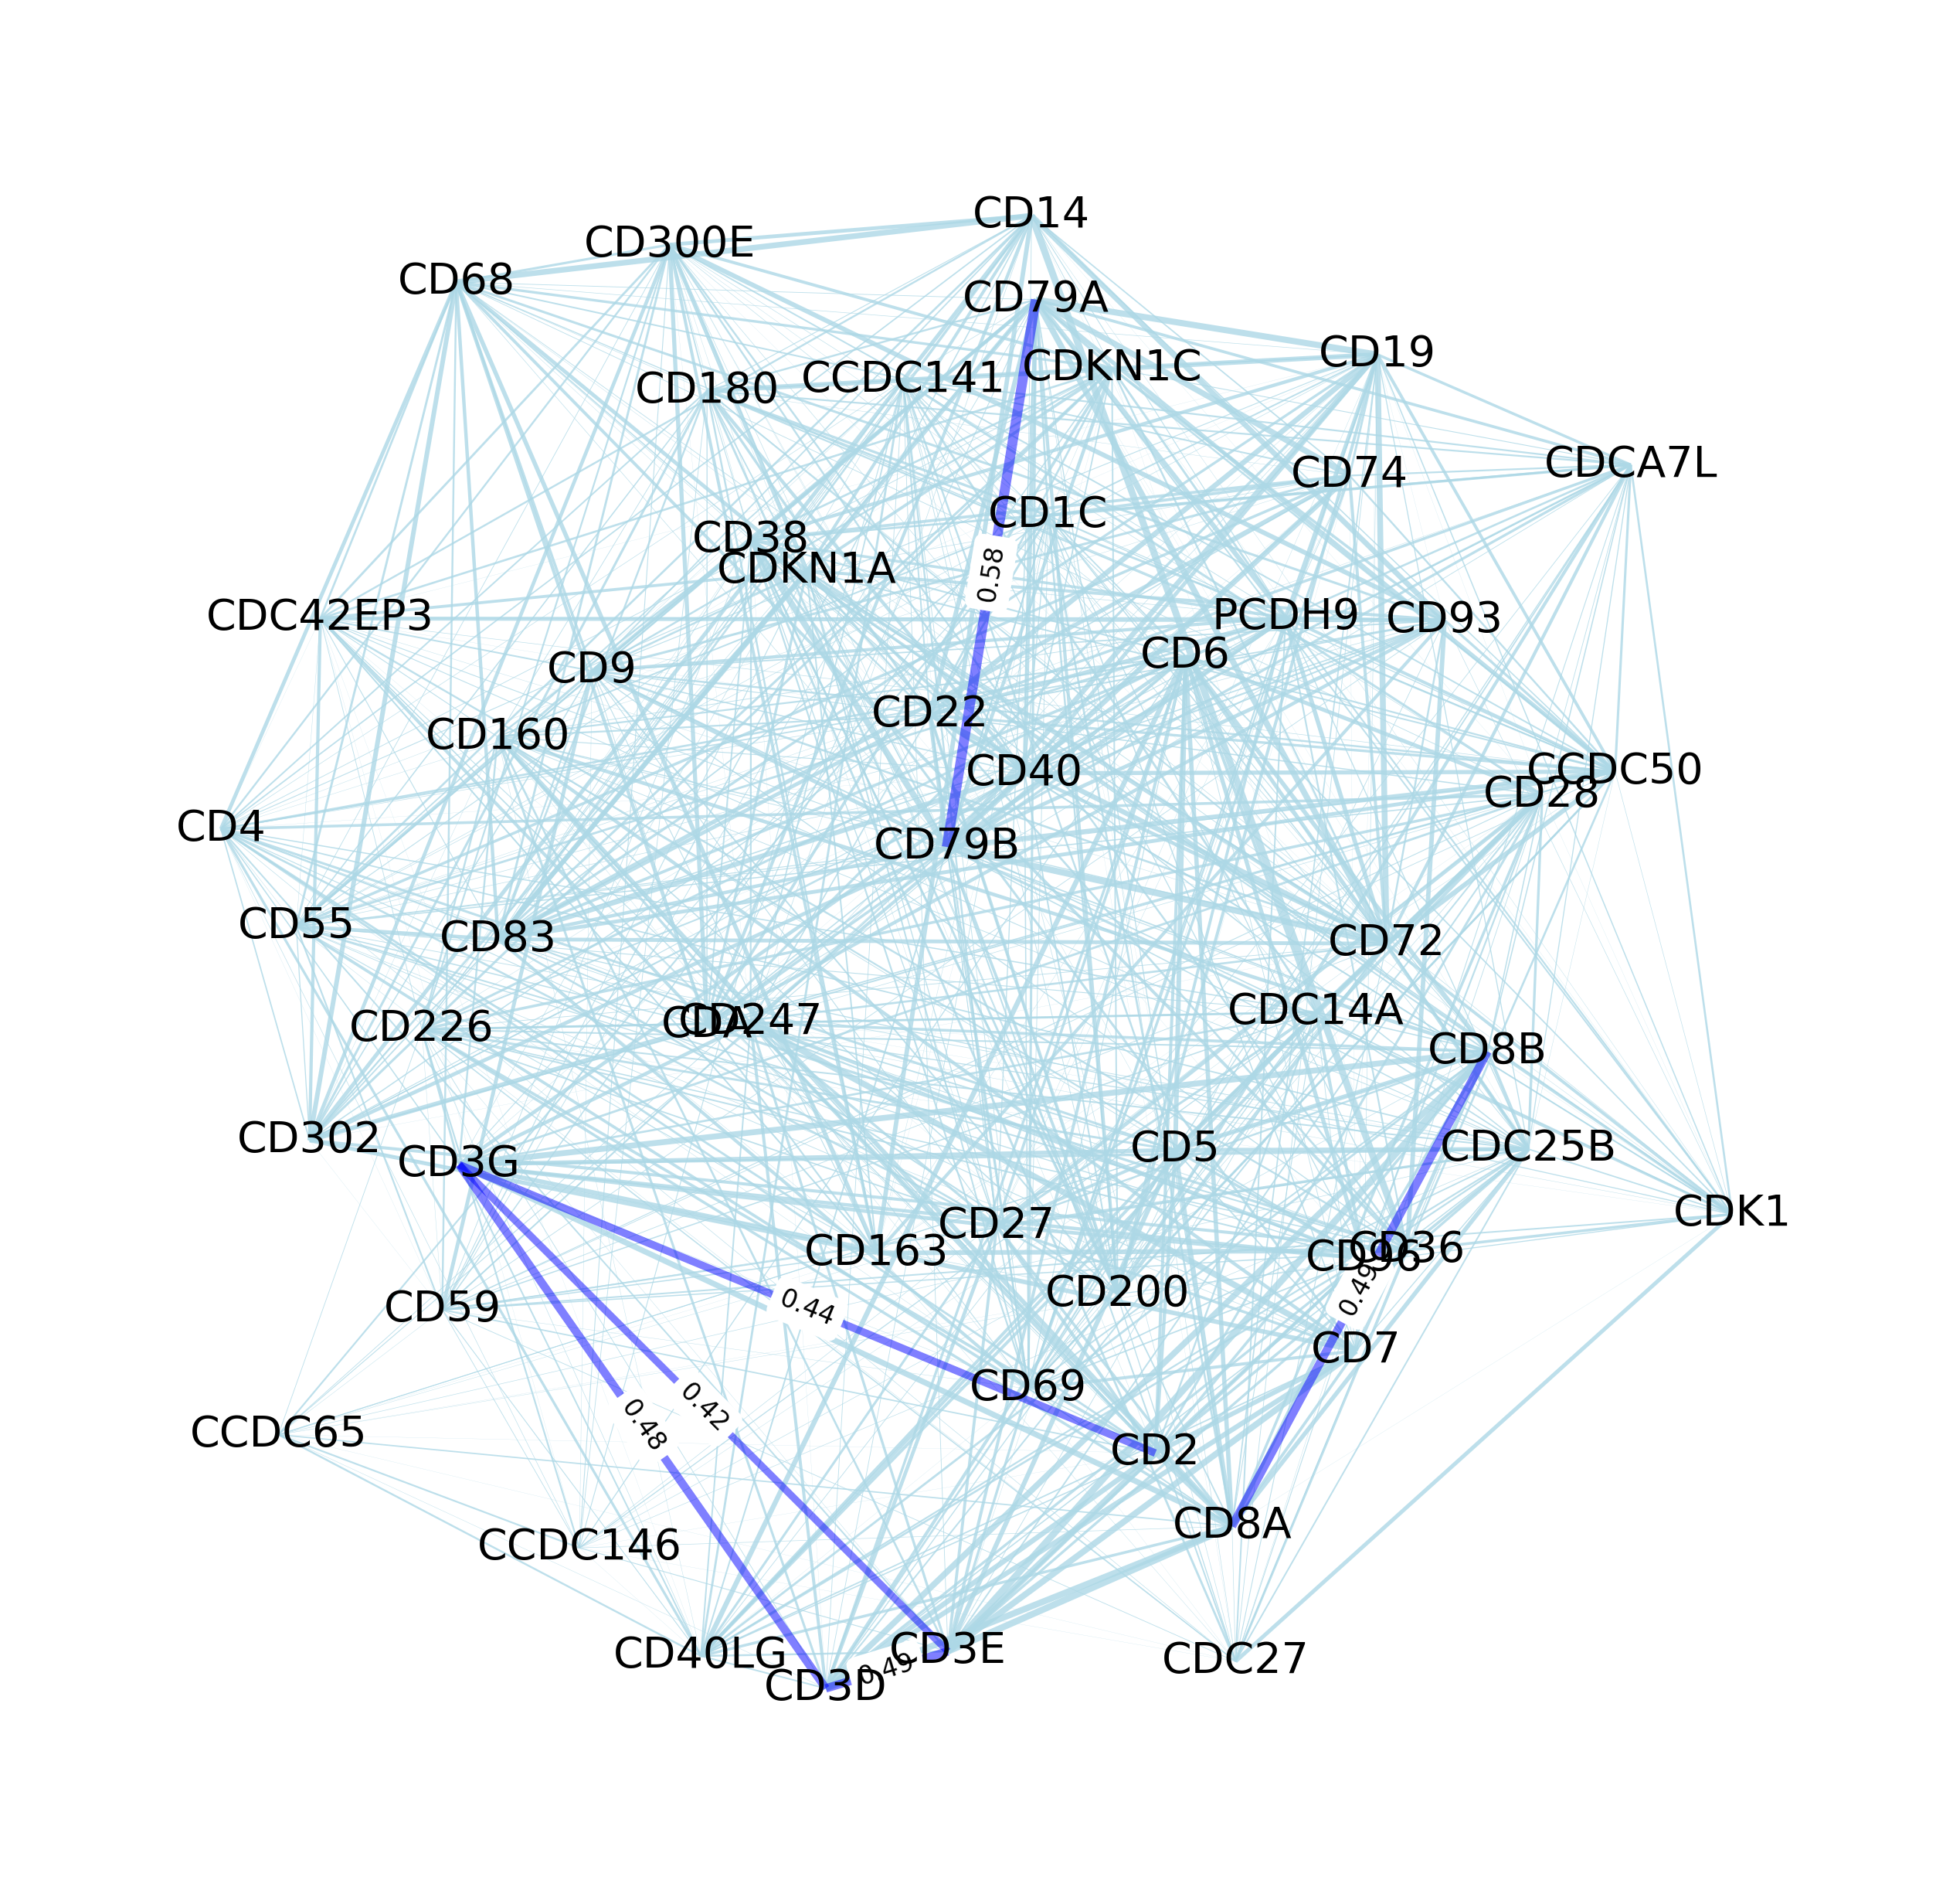

In [42]:
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.4]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.4]
#pos = nx.spring_layout(G, k=0.45, iterations=15, seed=4)
#pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)
pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)  # positions for all nodes - seed for reproducibility
# seed = 1 for fine-tuned
#pos = nx.shell_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
# nodes
#nx.draw_networkx_nodes(G, pos, node_size=700)
#nx.draw(G, pos, width=10*list(widths.values()))

# edges
# nx.draw_networkx_edges(G, pos, edgelist=elarge, width=4)
# nx.draw_networkx_edges(
#     G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
# )
width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > 0.4:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "b", 
                       #style="dashed"
                      )

# nx.draw_networkx_edges(G, pos,
#                        edgelist = widths.keys(),
#                        width=100*list(widths.values()),
#                        edge_color='lightblue',
#                        alpha=0.8)
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()

In [ ]:
# Rmb to not filter the HVGs when generating the HLA figure!!!

In [15]:
HLA_genes = [i for i in list(gene_embeddings.keys()) if 'HLA' in i]
out_blood = list(set(pathways['Immune System R-HSA-168256']))
HLA_genes = [i for i in HLA_genes if i in out_blood]

In [16]:
df_HLA = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(HLA_genes):
    df = embed.compute_similarities(i, HLA_genes)
    df['Gene1'] = i
    df_HLA = df_HLA.append(df)

100%|██████████| 17/17 [00:00<00:00, 93.98it/s]


In [17]:
df_HLA_sub = df_HLA[df_HLA['Similarity']<0.99].sort_values(by='Gene')

In [18]:
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_HLA_sub.iterrows()]

In [19]:
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

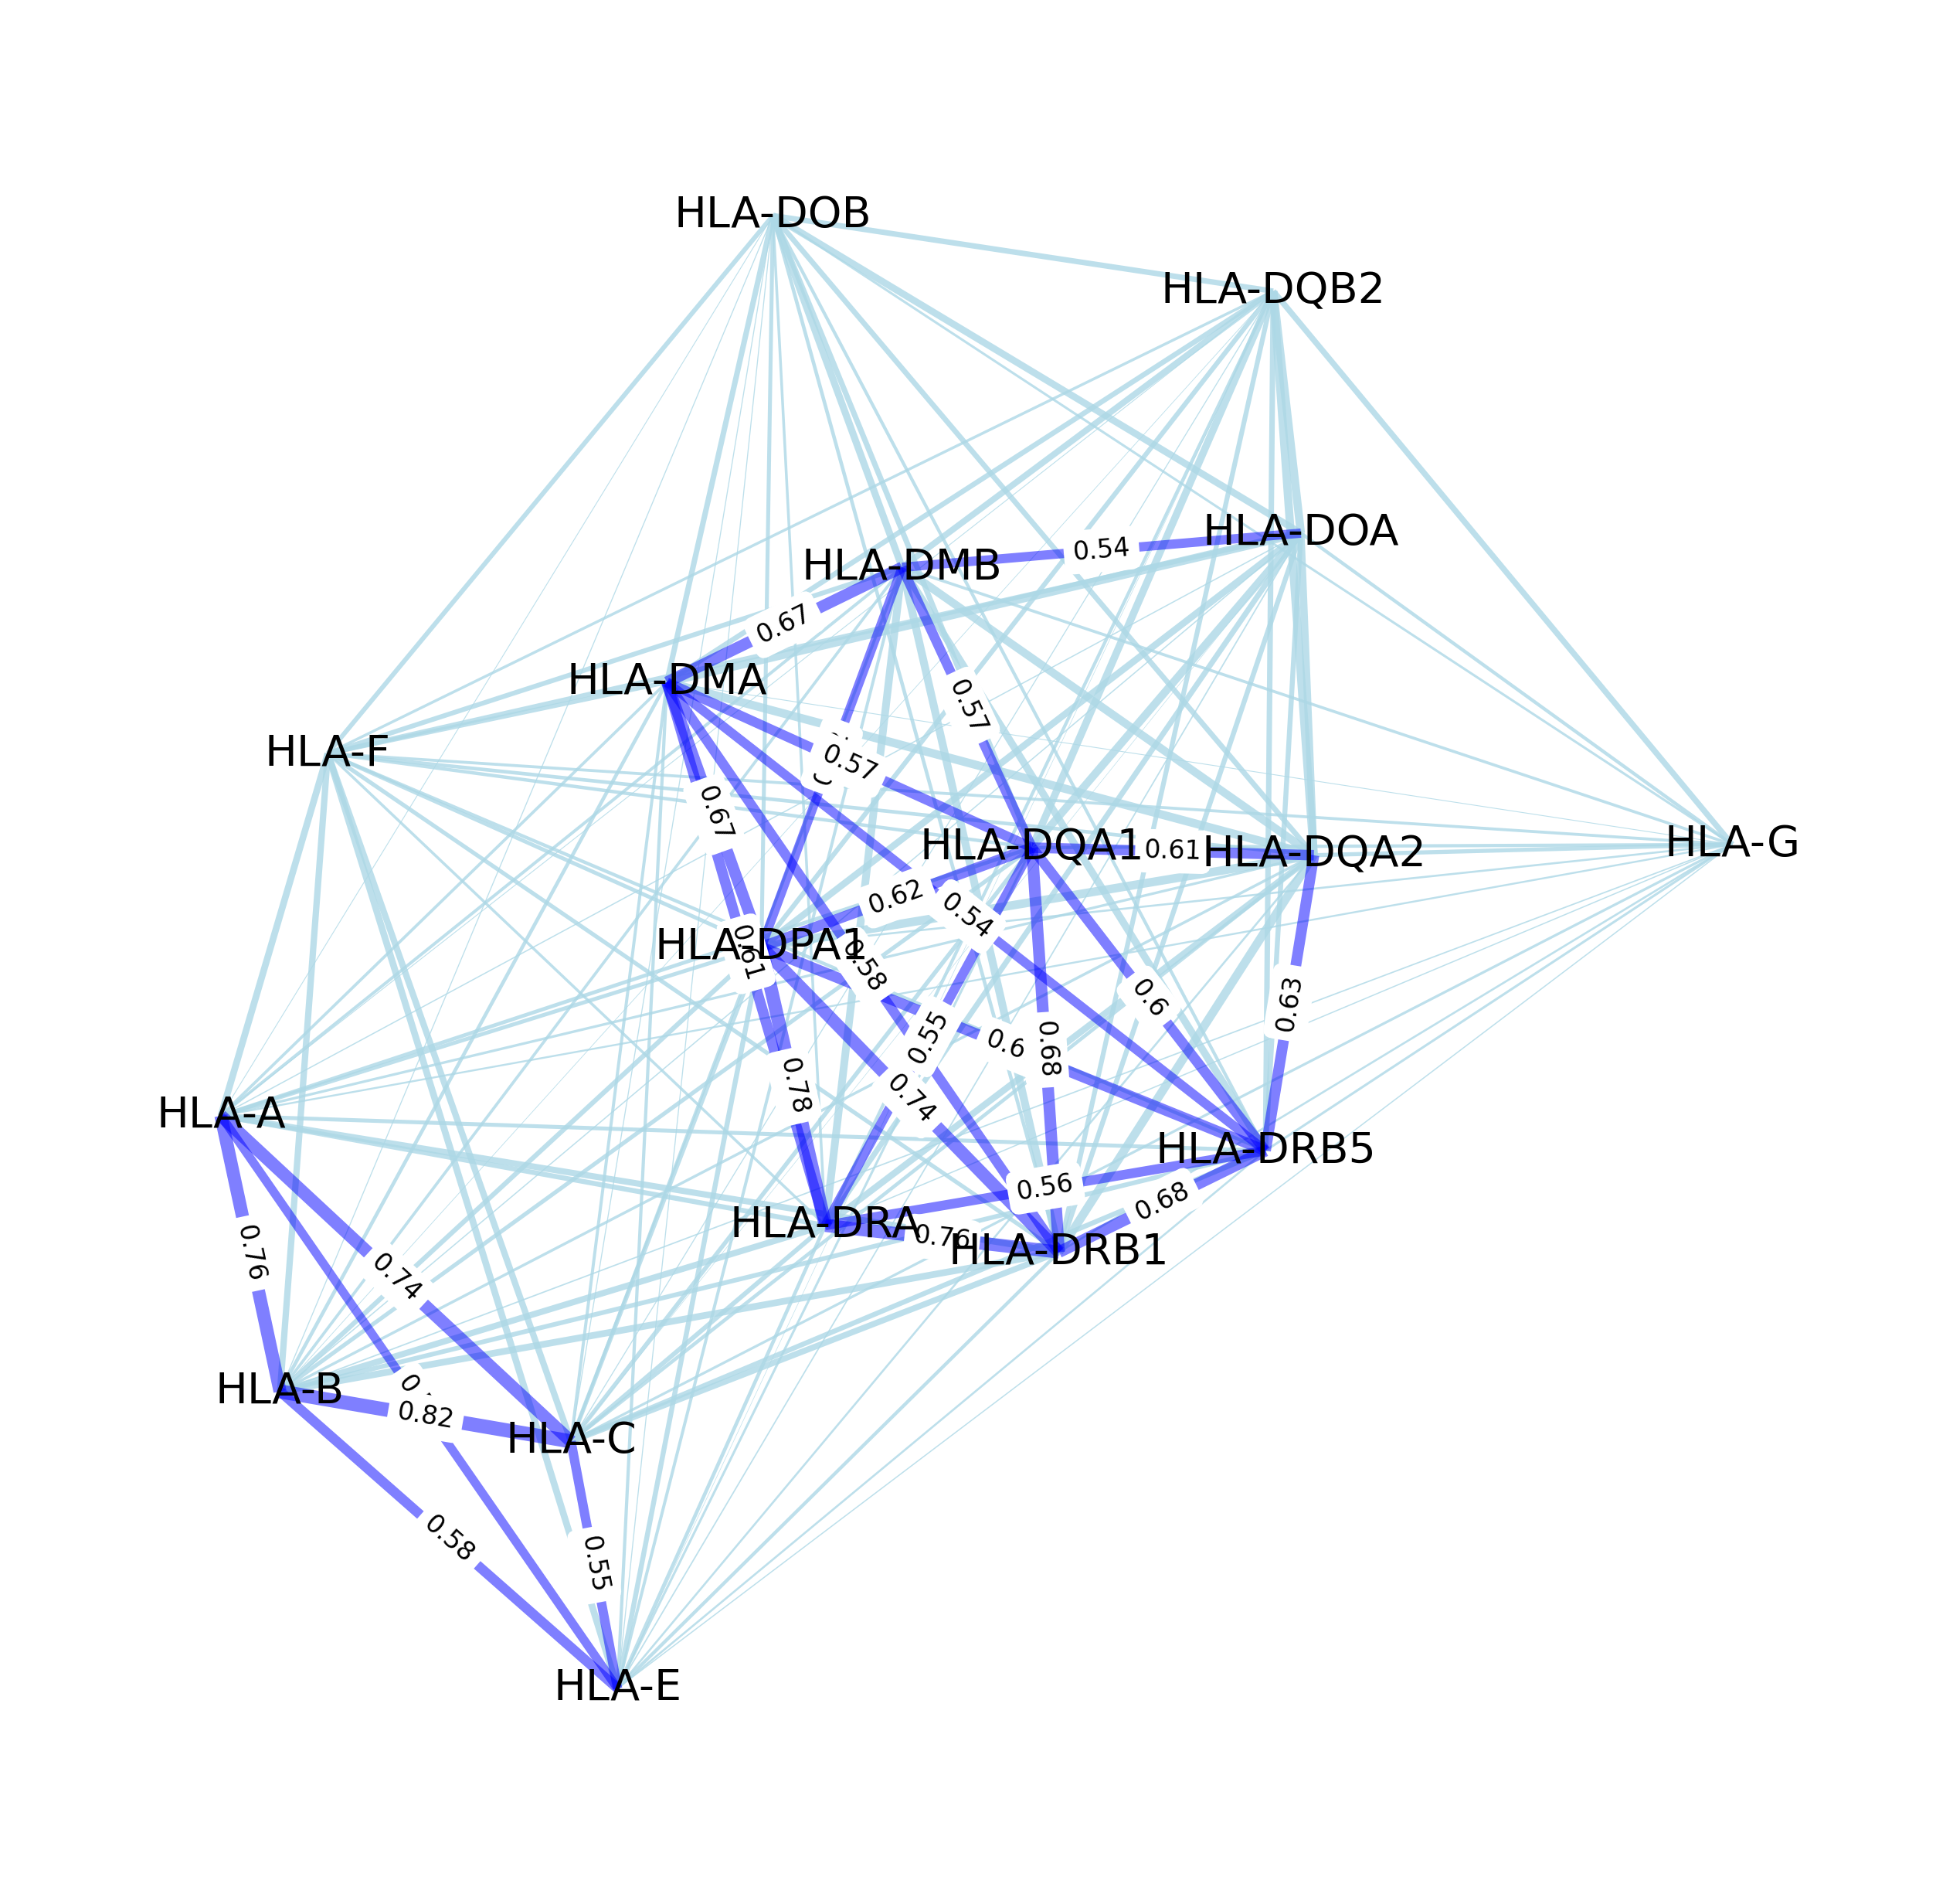

In [27]:
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, k=0.3, iterations=15, seed=3) 

#pos = nx.spring_layout(G, k=0.3, iterations=10, seed=1)  # positions for all nodes - seed for reproducibility
# seed = 1 for fine-tuned

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > 0.5:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos, 
                       edgelist = width_large.keys(), 
                       width = list(width_large.values()), 
                       alpha = 0.5, 
                       edge_color = "b", 
                       #style="dashed"
                      )

nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels

d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()

In [85]:
metagenes.items()

dict_items([('95', ['P2RY8', 'AHR', 'RBM38', 'RNF125']), ('64', ['IL3RA', 'IRF8', 'SPIB', 'IRF7', 'LILRA4']), ('293', ['ZNF836', 'TEPP']), ('258', ['ZNF683', 'FCRL6']), ('219', ['ZNF541', 'GTPBP2', 'RAB2B']), ('187', ['ZNF483', 'TSPYL2', 'ICA1L']), ('108', ['ZNF439', 'TBCEL', 'NSUN3', 'SWT1']), ('131', ['ZFP36', 'SOCS3', 'KLF10', 'CDKN1A']), ('253', ['ZFAND5', 'NAMPT', 'GABARAPL1']), ('7', ['ZEB2', 'SGK1', 'PICALM', 'RNF130', 'QKI', 'PDE4B', 'PTPRE']), ('40', ['ZCCHC7', 'SUPT3H', 'SCAPER', 'FHIT', 'TFDP2']), ('169', ['ZC3H12D', 'TRAF1', 'IL21R']), ('180', ['ZBTB25', 'SCML4', 'SLAMF6']), ('22', ['ZBTB16', 'TTC39C', 'SLC38A11', 'PIK3R1', 'FAM13A', 'NFIX']), ('259', ['YPEL4', 'NHLRC4']), ('166', ['YPEL3', 'BEX5', 'BEX2']), ('260', ['YOD1', 'MOSPD1']), ('15', ['YIPF6', 'GDE1', 'DPM2', 'CCS', 'PIGC', 'ATG4A', 'FAM104A']), ('10', ['XPO7', 'TRAK2', 'FBXO9', 'CDC27', 'NCEH1', 'OPA1', 'PPME1']), ('31', ['XCL2', 'LAIR2', 'KLRC1', 'KIR2DL3', 'XCL1', 'CRTAM']), ('12', ['VSIG4', 'FCGR3A', 'C1QA', '

In [86]:
adata

AnnData object with n_obs × n_vars = 33506 × 1200
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'celltype', '95_SCORE', '64_SCORE', '293_SCORE', '258_SCORE', '219_SCORE', '187_SCORE', '108_SCORE', '131_SCORE', '253_SCORE', '7_SCORE', '40_SCORE', '169_SCORE', '180_SCORE', '22_SCORE', '259_SCORE', '166_SCORE', '260_SCORE', '15_SCORE', '10_SCORE', '31_SCORE', '12_SCORE', '155_SCORE', '24_SCORE', '26_SCORE', '261_SCORE', '151_SCORE', '138_SCORE', '262_SCORE', '77_SCORE', '160_SCORE', '63_SCORE', '57_SCORE', '79_SCORE', '76_SCORE', '8_SCORE', '72_SCORE', '167_SCORE', '163_SCORE', '81_SCORE', '205_SCORE', '75_SCORE', '231_SCORE', '263_SCORE', '248_SCORE', '29_SCORE', '209_SCORE', '168_SCORE', '226_SCORE', '3_SCORE', '154_SCORE', '11_SCORE', '34_SCORE', '228_SCORE', '165_SCORE', '134_SCORE', '14_SCORE', '170_SCORE', '45_SCORE', '17_SCORE', '236_SCORE', '62_SCORE', '

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 400x1040 with 0 Axes>

<Figure size 320x320 with 0 Axes>

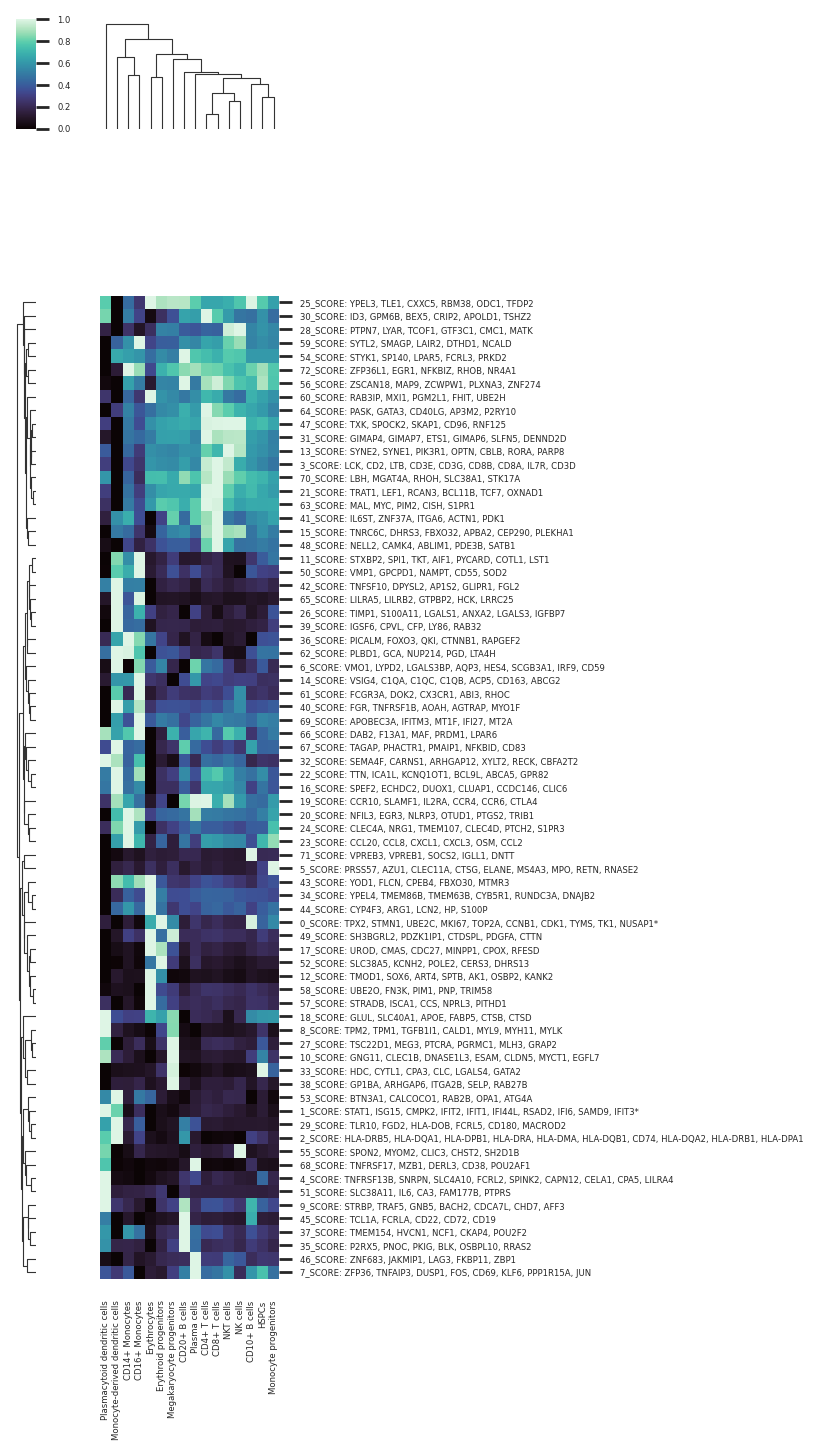

In [44]:
import numpy
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

sns.set(font_scale=0.35)

embed.plot_metagenes_scores(adata, mgs, "celltype")